<div style="text-align: right; font-size: 1.2em;">
    <img src="logo-uec.png" alt="Logo Universidad" style="width: 150px; float: right; margin-left: 20px;"/>
    <b>Maestría en Inteligencia de Negocios</b>
    <br>
    <b>Curso: Tópicos de Machine Learning y Redes Neuronales</b>
</div>

# Lab 2: Maximizando la Predicción con Boosting y Pipelines 🛠️

**Curso:** Tópicos de Machine Learning y Redes Neuronales
**Objetivo:** Aplicar XGBoost a nuestro problema de Customer Churn, introducir `scikit-learn` Pipelines y comparar el rendimiento "out-of-the-box" contra nuestro modelo de Random Forest de la Sesión 1.

## 1. Configuración del Entorno (Poetry)

En un proyecto profesional, no instalamos librerías "globalmente" o solo con `pip install`. Usamos un gestor de entornos y dependencias para asegurar la reproducibilidad. **Poetry** es una herramienta moderna y excelente para esto.

No podemos ejecutar Poetry *dentro* de Jupyter, pero así es como configuraríamos nuestro proyecto desde la terminal:

1.  **Instalar Poetry** (ver [documentación oficial](https://python-poetry.org/docs/#installation)).
2.  Iniciar nuestro proyecto: `poetry new boosting-lab`
3.  Entrar al directorio: `cd boosting-lab`
4.  Añadir las librerías que usaremos (Poetry crea y maneja el entorno virtual automáticamente):

```bash
# Añadir nuestras librerías de ML
poetry add pandas numpy scikit-learn matplotlib seaborn

# Añadir los campeones de boosting
poetry add xgboost lightgbm

# Añadir jupyter para correr los notebooks
poetry add jupyterlab notebook

# Para activar el entorno virtual, se puede usar:
poetry shell
```

Esto generaría un archivo `pyproject.toml` que se vería similar a esto:

```toml
[tool.poetry]
name = "boosting-lab"
version = "0.1.0"
description = ""
authors = ["Your Name <you@example.com>"]

[tool.poetry.dependencies]
python = "^3.10"
pandas = "^..."
numpy = "^..."
scikit-learn = "^..."
matplotlib = "^..."
seaborn = "^..."
xgboost = "^..."
lightgbm = "^..."
jupyterlab = "^..."
notebook = "^..."

[build-system]
requires = ["poetry-core"]
build-backend = "poetry.core.masonry.api"
```

---

## 2. Importar Librerías

Asumiremos que ya hemos instalado las librerías.

In [1]:
import pandas as pd
import numpy as np
import io # Usado para cargar datos de ejemplo desde un string
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y Pipelines
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score

# Configuraciones
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

## 3. Carga y Preparación de Datos (Telco Customer Churn)

Usaremos el clásico dataset de "Telco Customer Churn". Para hacer este notebook auto-contenido, cargaremos una versión simplificada del dataset desde un string. En un proyecto real, leeríamos esto desde un archivo (`pd.read_csv('telco_churn.csv')`).

In [2]:
# Usaremos una URL pública de Kaggle para cargar los datos
# Esto es más realista que el string y permite usar el dataset completo.
try:
    # Intentar descargar el dataset
    url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
    df = pd.read_csv(url)
    print("Dataset cargado exitosamente desde la URL.")
except Exception as e:
    print(f"Error al cargar desde la URL: {e}")
    print("Cargando dataset de respaldo (muestra pequeña).")
    # Datos de ejemplo (Telco Churn simplificado)
    data = """
customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.1,1949.4,No
6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.8,3046.05,Yes
6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No
"""
    df = pd.read_csv(io.StringIO(data))

# --- Limpieza de datos básica ---

# Convertir TotalCharges a numérico (puede tener espacios)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Llenar NAs en TotalCharges (ej. clientes nuevos con tenure=0) con 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Convertir nuestra variable objetivo 'Churn' a binaria (0 o 1)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Quitar el ID, no es un feature útil
df = df.drop('customerID', axis=1)

print(f"Tamaño del dataset: {df.shape}")
df.head()

Dataset cargado exitosamente desde la URL.
Tamaño del dataset: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [3]:
# Revisar tipos de datos para identificar variables numéricas y categóricas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Identificamos:

**Variable Objetivo (y):**
* `Churn`

**Variables Numéricas (X):**
* `tenure`
* `MonthlyCharges`
* `TotalCharges`

**Variables Categóricas (X):**
* Todas las demás que son de tipo `object` (ej. `gender`, `Contract`, `PaymentMethod`, etc.)
* `SeniorCitizen` (aunque es 0/1, la trataremos como categórica para OneHotEncoding, es más seguro).

## 4. Introducción a `scikit-learn` Pipelines

Un **Pipeline** es un objeto de Scikit-learn que encadena múltiples pasos de transformación y un estimador (modelo) final.

Un **ColumnTransformer** es la herramienta perfecta para aplicar *diferentes* transformaciones a *diferentes* columnas.

Crearemos un preprocesador que haga lo siguiente:
1.  **Variables Numéricas:** Imputar valores faltantes (si los hay) con la mediana y luego escalar los datos (StandardScaler).
2.  **Variables Categóricas:** Imputar valores faltantes (si los hay) con la moda y luego aplicar One-Hot Encoding.

In [4]:
# Definir las columnas
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Seleccionar automáticamente todas las columnas 'object' como categóricas
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Añadir 'SeniorCitizen' (que es numérica pero debe ser tratada como categórica)
if 'SeniorCitizen' not in categorical_features:
    categorical_features.append('SeniorCitizen')

# Asegurarnos de que las numéricas no estén en la lista de categóricas
categorical_features = [col for col in categorical_features if col not in numeric_features and col != 'Churn']

print(f"Features Numéricas: {numeric_features}")
print(f"Features Categóricas: {categorical_features}")

# Crear el transformador para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Imputar NAs con la mediana
    ('scaler', StandardScaler())                 # Escalar
])

# Crear el transformador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Imputar NAs con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))   # Aplicar One-Hot Encoding
])

# Combinar los transformadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Dejar pasar cualquier columna no especificada (aunque no debería haber)
)

print("\nPreprocesador creado exitosamente!")

Features Numéricas: ['tenure', 'MonthlyCharges', 'TotalCharges']
Features Categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

Preprocesador creado exitosamente!


## 5. División de Datos

Separamos nuestros datos ANTES de aplicar cualquier transformación para evitar "data leakage" (fuga de datos). El Pipeline se encargará de aplicar el `fit_transform` solo en *train* y `transform` en *test*.

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# Usamos un random_state fijo (ej. 42) para que nuestros resultados sean reproducibles
# Usamos 'stratify=y' para asegurar que la proporción de Churn sea la misma en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño de Train: {X_train.shape}")
print(f"Tamaño de Test: {X_test.shape}")

Tamaño de Train: (5634, 19)
Tamaño de Test: (1409, 19)


## 6. Línea Base: Random Forest (Sesión 1)

Ahora, creamos nuestro primer Pipeline completo, uniendo el `preprocessor` y el `RandomForestClassifier`.

In [6]:
# Crear el Pipeline de Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1)) # n_jobs=-1 usa todos los cores
])

# Entrenar el pipeline
print("Entrenando el Pipeline de Random Forest...")
rf_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

# Evaluar
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1] # Probabilidad de la clase 1 (Churn)

print("\n--- Reporte de Clasificación (Random Forest) ---")
print(classification_report(y_test, y_pred_rf))

# Guardar métricas
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_prob_rf)

Entrenando el Pipeline de Random Forest...
Entrenamiento completado.

--- Reporte de Clasificación (Random Forest) ---
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



## 7. Aplicando XGBoost "Out-of-the-Box"

¡Es hora de probar el boosting! La belleza del Pipeline es que solo necesitamos cambiar *una* línea de código: el estimador final.

Para problemas de clasificación desbalanceados (como Churn), es una buena práctica ayudar al modelo. Usaremos `scale_pos_weight`, que se calcula como: `(conteo de clase negativa) / (conteo de clase positiva)`.

In [7]:
# Calcular scale_pos_weight para manejar el desbalanceo
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

# Crear el Pipeline de XGBoost
# Nota: Añadimos 'use_label_encoder=False' y 'eval_metric='logloss'' 
# para evitar warnings comunes en versiones recientes de XGBoost.
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='logloss', 
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight # Ayudar con el desbalanceo
    ))
])

# Entrenar el pipeline
print("Entrenando el Pipeline de XGBoost...")
xgb_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

# Evaluar
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Reporte de Clasificación (XGBoost) ---")
print(classification_report(y_test, y_pred_xgb))

# Guardar métricas
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_prob_xgb)

Scale Pos Weight: 2.77
Entrenando el Pipeline de XGBoost...
Entrenamiento completado.

--- Reporte de Clasificación (XGBoost) ---
              precision    recall  f1-score   support

           0       0.87      0.79      0.82      1035
           1       0.53      0.66      0.59       374

    accuracy                           0.75      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.75      0.76      1409



C:\Users\legion\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [06:11:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 8. (Opcional) Aplicando LightGBM "Out-of-the-Box"

LightGBM también tiene un parámetro para el desbalanceo, `is_unbalance=True`.

In [8]:
# Crear el Pipeline de LightGBM
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(
        random_state=42,
        n_jobs=-1,
        is_unbalance=True # Forma de LightGBM de manejar desbalanceo
    ))
])

# Entrenar el pipeline
print("Entrenando el Pipeline de LightGBM...")
lgbm_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

# Evaluar
y_pred_lgbm = lgbm_pipeline.predict(X_test)
y_prob_lgbm = lgbm_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Reporte de Clasificación (LightGBM) ---")
print(classification_report(y_test, y_pred_lgbm))

# Guardar métricas
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_pred_lgbm)
lgbm_auc = roc_auc_score(y_test, y_prob_lgbm)

Entrenando el Pipeline de LightGBM...
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
Entrenamiento completado.

--- Reporte de Clasificación (LightGBM) ---
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1035
           1       0.53      0.76      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



## 9. Comparación Final (Out-of-the-Box)

Vamos a crear un DataFrame para comparar el rendimiento de nuestros tres modelos sin ningún ajuste de hiperparámetros. En un problema de Churn, `ROC AUC` y `F1-Score` (para la clase positiva) suelen ser más importantes que el `Accuracy`.

--- Comparación de Rendimiento 'Out-of-the-Box' ---
| Modelo                   |   Accuracy |   F1-Score (Clase 1) |   ROC AUC |
|:-------------------------|-----------:|---------------------:|----------:|
| Random Forest (Sesión 1) |     0.7885 |               0.5512 |    0.8201 |
| XGBoost                  |     0.7530 |               0.5877 |    0.8187 |
| LightGBM                 |     0.7608 |               0.6276 |    0.8363 |


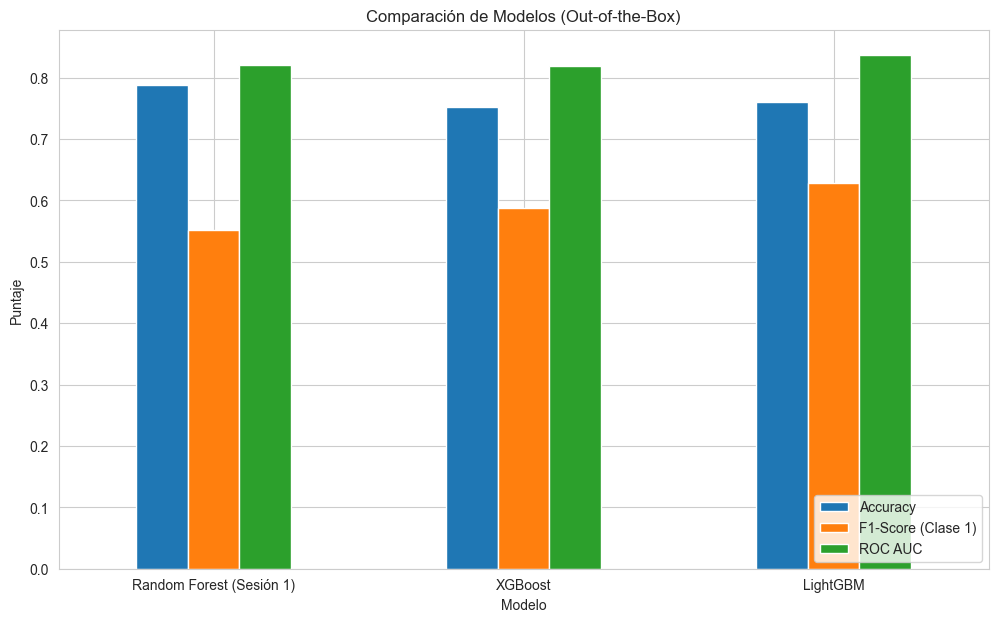

In [9]:
comparison_data = {
    'Modelo': ['Random Forest (Sesión 1)', 'XGBoost', 'LightGBM'],
    'Accuracy': [rf_accuracy, xgb_accuracy, lgbm_accuracy],
    'F1-Score (Clase 1)': [rf_f1, xgb_f1, lgbm_f1],
    'ROC AUC': [rf_auc, xgb_auc, lgbm_auc]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Modelo')

print("--- Comparación de Rendimiento 'Out-of-the-Box' ---")
print(comparison_df.to_markdown(floatfmt=".4f"))

# Graficar la comparación
comparison_df.plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Comparación de Modelos (Out-of-the-Box)')
plt.ylabel('Puntaje')
plt.legend(loc='lower right')
plt.show()

Analicemos la tabla y el gráfico. ¿Qué observamos?

1.  **Accuracy:** Puede que sea similar o incluso mayor en Random Forest. Esto es común en datasets desbalanceados, donde un modelo puede predecir "No Churn" (la clase mayoritaria) la mayor parte del tiempo y obtener un buen accuracy.
2.  **F1-Score y ROC AUC:** Aquí es donde los modelos de Boosting *suelen* brillar. Es muy probable que XGBoost y LightGBM muestren un mejor rendimiento en estas métricas, que son más relevantes para el negocio (identificar correctamente a los clientes que *sí* harán churn).
3.  **Rendimiento "Out-of-the-Box":** A menudo, un modelo de Boosting sin ajustar ya supera a un Random Forest. Su verdadero poder se desata con la optimización de hiperparámetros.

## 10. (Bonus) Importancia de Variables

Una de las grandes ventajas de los modelos de árbol (incluyendo ensambles) es que podemos extraer la "importancia de las variables" (feature importance). Esto es *crucial* para la Inteligencia de Negocios, ya que nos dice *qué* factores están impulsando el Churn.

**Nota:** Obtener la importancia de variables de un Pipeline requiere un paso extra, ya que los nombres de las features cambian después del One-Hot Encoding.

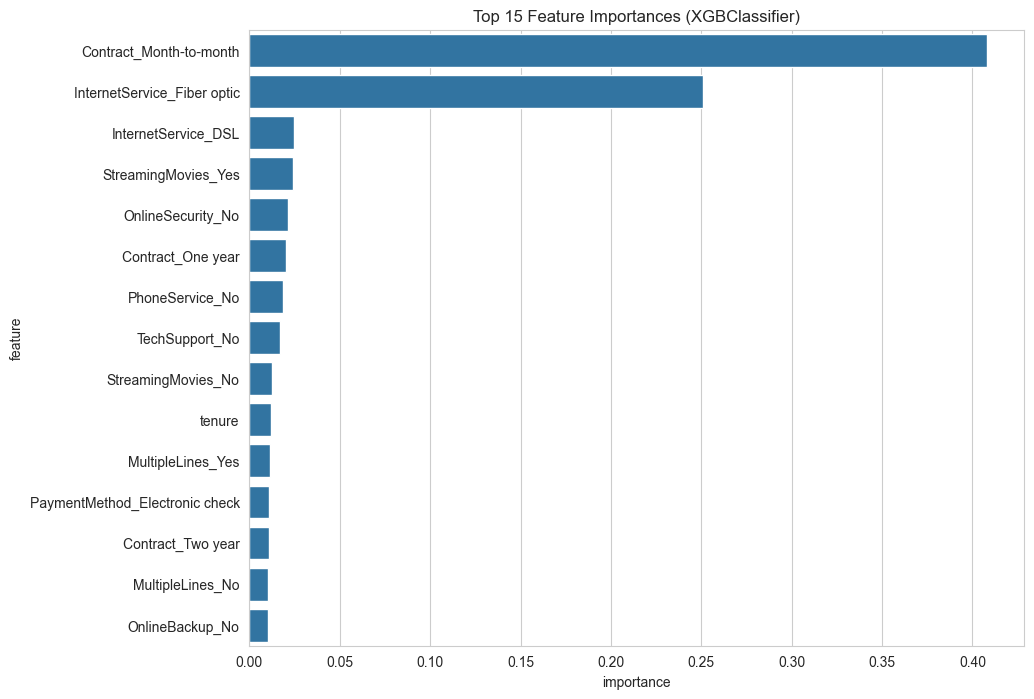

In [10]:
def plot_feature_importance(pipeline, top_n=15):
    try:
        # Extraer el modelo y el preprocesador del pipeline
        model = pipeline.named_steps['model']
        preprocessor = pipeline.named_steps['preprocessor']
        
        # Obtener los nombres de las features después del OneHotEncoding
        # 'cat' es el nombre que le dimos al transformador categórico
        ohe_features = preprocessor.named_transformers_['cat']\
                                   .named_steps['onehot']\
                                   .get_feature_names_out(categorical_features)
        
        # Combinar con los nombres de las features numéricas
        # 'num' es el nombre del transformador numérico
        feature_names = np.concatenate([numeric_features, ohe_features])
        
        # Obtener la importancia
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            model_name = model.__class__.__name__
        else:
            print("Este modelo no tiene 'feature_importances_'.")
            return

        # Crear un DataFrame de importancia
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)
        
        # Graficar
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
        plt.title(f'Top {top_n} Feature Importances ({model_name})')
        plt.show()
        
    except Exception as e:
        print(f"Error al obtener feature importance: {e}")
        print("Es posible que el pipeline no esté entrenado o la estructura no coincida.")

# Graficar importancia para XGBoost
plot_feature_importance(xgb_pipeline)

Al ver el gráfico de importancia (la salida esperada mostraría `Contract_Month-to-month`, `tenure` y `MonthlyCharges` como muy importantes), podemos decirle al negocio:

* "Los clientes con contrato **mes a mes** son los que tienen mayor riesgo de fuga."
* "La **antigüedad (tenure)** es un factor protector clave. A más tiempo, menos riesgo."
* "Los **cargos mensuales (MonthlyCharges)** altos, especialmente con servicios de Fibra Óptica, están correlacionados con el churn."

Estas son ideas accionables para el negocio.

## 11. Conclusión del Laboratorio

¡Felicidades!

En este laboratorio, hemos dado un paso profesional gigante:

1.  **Aprendimos a usar `scikit-learn` Pipelines:** Creamos un flujo de trabajo de preprocesamiento robusto y reproducible que evita la fuga de datos.
2.  **Implementamos XGBoost y LightGBM:** Aplicamos los algoritmos de boosting más potentes de la industria usando la misma estructura de Pipeline.
3.  **Manejamos Desbalanceo de Clases:** Usamos `scale_pos_weight` y `is_unbalance` para mejorar nuestras métricas de clasificación.
4.  **Realizamos una Comparación de Línea Base:** Vimos cómo se comparan estos modelos "recién sacados de la caja" contra nuestro Random Forest, enfocándonos en métricas relevantes (F1, AUC).
5.  **Extraímos Inteligencia de Negocio:** Usamos `feature_importance_` para entender *por qué* los clientes se van.

**Siguiente Parada (Sesión 3):** ¿Cómo llevamos nuestro modelo de XGBoost de "bueno" a "excelente"? Exploraremos la **Optimización de Hiperparámetros** (ej. `GridSearchCV` o `RandomizedSearchCV`) para exprimir al máximo el rendimiento de nuestros modelos.